# 1. Data

## 1.1 Imports

In [101]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.manifold import TSNE

from sklearn.metrics import precision_score,classification_report, confusion_matrix, plot_precision_recall_curve, plot_roc_curve,recall_score, precision_recall_curve,f1_score
from sklearn.preprocessing import RobustScaler
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import cross_validate, train_test_split
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer

from imblearn.under_sampling import RandomUnderSampler
from imblearn.over_sampling import RandomOverSampler, SMOTE
from imblearn.ensemble import BalancedBaggingClassifier
from imblearn.pipeline import Pipeline as Pipeline_imb


## 1.2 Useful functions

In [22]:
def plot_report(model,X_test,y_test,model_name,figsize):
    
    '''Plots metrics, curves and the classification report'''
    
    f, ax = plt.subplots(nrows = 2, ncols = 2, figsize=figsize)

    '''Confusion matrix'''
    sns.heatmap(confusion_matrix(y_test,model.predict(X_test)), annot = True, 
                cbar = False, ax= ax[0,0],fmt='d', cmap = 'gray',annot_kws={"fontsize":20})
    
    ax[0,0].set_xlabel('Prediction',fontsize = 10)
    ax[0,0].set_ylabel('True',fontsize = 10)
    ax[0,0].set_title('Confusion matrix', fontsize = 15)
    
    
    '''Clasification report'''
    report = classification_report(y_test, model.predict(X_test), output_dict=True)
    sns.heatmap(pd.DataFrame(report).transpose()[['precision', 'recall','f1-score']], 
                annot = True, cbar = False,fmt='.2f', ax = ax[0,1], cmap= 'RdYlGn')
    ax[0,1].set_title('Classification report', fontsize = 15)


    '''PR Curve'''
    plot_precision_recall_curve(model,X_test,y_test,name = model_name, ax = ax[1,0])
    ax[1,0].set_title('Precision-Recall Curve', fontsize = 15)
    
    '''ROC Curve'''
    plot_roc_curve(model,X_test,y_test,name = model_name, ax = ax[1,1])
    ax[1,1].set_title('ROC', fontsize = 15)


    plt.tight_layout()
    plt.show()

In [293]:
def pred_report(pred,X_test,y_test,figsize):
    
    '''Plots metrics, curves and the classification report'''
    
    f, ax = plt.subplots(ncols = 2, figsize=figsize)

    '''Confusion matrix'''
    sns.heatmap(confusion_matrix(y_test,pred), annot = True, 
                cbar = False, ax= ax[0],fmt='d', cmap = 'gray',annot_kws={"fontsize":20})
    
    ax[0].set_xlabel('Prediction',fontsize = 10)
    ax[0].set_ylabel('True',fontsize = 10)
    ax[0].set_title('Confusion matrix', fontsize = 15)
    
    
    '''Clasification report'''
    report = classification_report(y_test, pred, output_dict=True)
    sns.heatmap(pd.DataFrame(report).transpose()[['precision', 'recall','f1-score']], 
                annot = True, cbar = False,fmt='.2f', ax = ax[1], cmap= 'RdYlGn')
    ax[1].set_title('Classification report', fontsize = 15)

    plt.tight_layout()
    plt.show()

In [3]:
data = pd.read_csv("data/creditcard.csv")

## 1.3 EDA

In [3]:
data.head(5)

,Time,V1,V2,V3,V4,V5,V6,V7,V8,V9,...,V21,V22,V23,V24,V25,V26,V27,V28,Amount,Class
0,0.0,-1.359807,-0.072781,2.536347,1.378155,-0.338321,0.462388,0.239599,0.098698,0.363787,...,-0.018307,0.277838,-0.110474,0.066928,0.128539,-0.189115,0.133558,-0.021053,149.62,0
1,0.0,1.191857,0.266151,0.166480,0.448154,0.060018,-0.082361,-0.078803,0.085102,-0.255425,...,-0.225775,-0.638672,0.101288,-0.339846,0.167170,0.125895,-0.008983,0.014724,2.69,0
2,1.0,-1.358354,-1.340163,1.773209,0.379780,-0.503198,1.800499,0.791461,0.247676,-1.514654,...,0.247998,0.771679,0.909412,-0.689281,-0.327642,-0.139097,-0.055353,-0.059752,378.66,0
3,1.0,-0.966272,-0.185226,1.792993,-0.863291,-0.010309,1.247203,0.237609,0.377436,-1.387024,...,-0.108300,0.005274,-0.190321,-1.175575,0.647376,-0.221929,0.062723,0.061458,123.50,0
4,2.0,-1.158233,0.877737,1.548718,0.403034,-0.407193,0.095921,0.592941,-0.270533,0.817739,...,-0.009431,0.798278,-0.137458,0.141267,-0.206010,0.502292,0.219422,0.215153,69.99,0


- **Time**: It is only a counter.
- **V1-V28**: Anonymized data.
- **Amount**: Transaction amount.
- **Class**: Fraud = 1, Normal = 0.

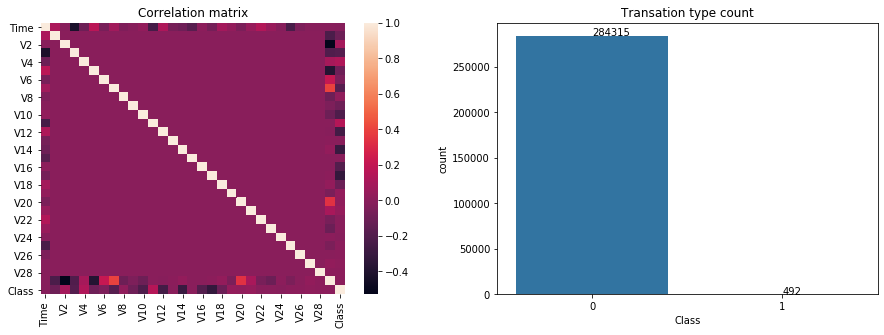

In [4]:
f, ax = plt.subplots(nrows=1 , ncols=2 ,figsize=(15,5))

sns.countplot(data["Class"], ax=ax[1])
ax[1].annotate(len(data[data["Class"]==1]),(1,len(data[data["Class"]==1])))
ax[1].annotate(len(data[data["Class"]==0]),(0,len(data[data["Class"]==0])))
sns.heatmap(data.corr(), ax=ax[0])

ax[1].set_title("Transation type count")
ax[0].set_title("Correlation matrix")

plt.show()

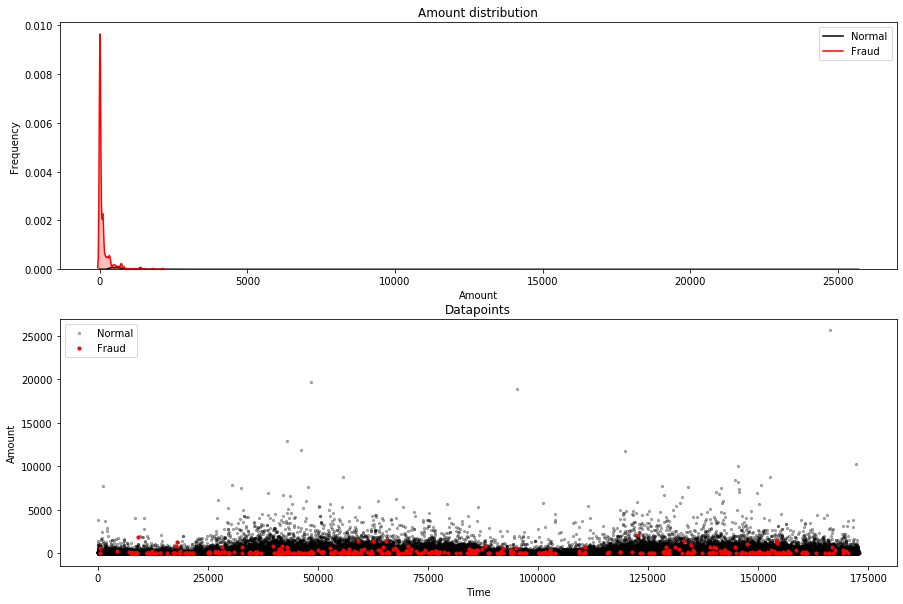

In [5]:
f, ax = plt.subplots(nrows = 2,figsize=(15,10))

sns.kdeplot(data[data["Class"]==0]["Amount"],shade=True,color='k',label='Normal',ax = ax[0])
sns.kdeplot(data[data["Class"]==1]["Amount"],shade=True,color='r',label='Fraud',ax = ax[0])

ax[0].set_title('Amount distribution')
ax[0].set_ylabel('Frequency')
ax[0].set_xlabel('Amount')

ax[1].scatter(data[data["Class"]==0]["Time"],
            data[data["Class"]==0]["Amount"],
            s=5,alpha=0.3,
            label="Normal",
            c="k")

ax[1].scatter(data[data["Class"]==1]["Time"],
            data[data["Class"]==1]["Amount"],
            s=10,
            label="Fraud",
            c="r")

ax[1].set_xlabel("Time")
ax[1].set_ylabel("Amount")
ax[1].set_title('Datapoints')

plt.legend()
plt.show()

This dataset has high dimentionality, so visualization is a problem. Doing pairplots for every variable isn't functional, so I proced with a t-SNE technique to get a 2D plot of the data. Also, I will take only a subsample of normal class for this viz.

In [157]:
subdata = data.copy()
subdata.iloc[:,1:30] = RobustScaler().fit_transform(subdata.iloc[:,1:30])

tsne = TSNE(n_components=2, random_state = 26)
subsample = pd.concat([subdata[subdata['Class']==0].sample(150000),subdata[subdata['Class']==1]])
data_viz = tsne.fit_transform(subsample.drop('Class',axis=1))

color = ['red' if i == 1 else 'k' for i in subsample['Class']]
size = [10 if i == 1 else 1 for i in subsample['Class']]


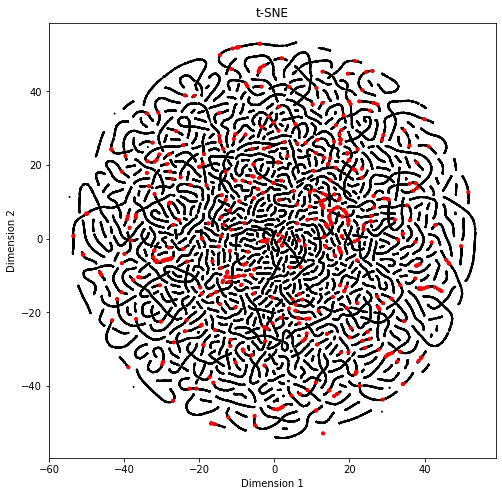

In [158]:
plt.figure(figsize=(8,8))
plt.scatter(pd.DataFrame(data_viz)[0],pd.DataFrame(data_viz)[1], color = color,  s= size)
plt.title('t-SNE')
plt.xlabel('Dimension 1')
plt.ylabel('Dimension 2')
plt.show()

The red dots represent frauds, and there are very close to normal transaction.

# 2. Models

## 2.1 LogisticRegression - Baseline

In [212]:
X_train, X_test, y_train, y_test = train_test_split(data.drop(['Class','Time'],axis=1),
                                                    data['Class'],
                                                    test_size = 0.2)

X_train, X_val, y_train, y_val = train_test_split(X_train,
                                                  y_train,
                                                  test_size = 0.2)

In [213]:
baseline = Pipeline([('scaler',RobustScaler()),
                     ('classifier',LogisticRegression(max_iter = 100000))])

baseline.fit(X_train,y_train)

Pipeline(memory=None,
         steps=[('scaler',
                 RobustScaler(copy=True, quantile_range=(25.0, 75.0),
                              with_centering=True, with_scaling=True)),
                ('classifier',
                 LogisticRegression(C=1.0, class_weight=None, dual=False,
                                    fit_intercept=True, intercept_scaling=1,
                                    l1_ratio=None, max_iter=100000,
                                    multi_class='auto', n_jobs=None,
                                    penalty='l2', random_state=None,
                                    solver='lbfgs', tol=0.0001, verbose=0,
                                    warm_start=False))],
         verbose=False)

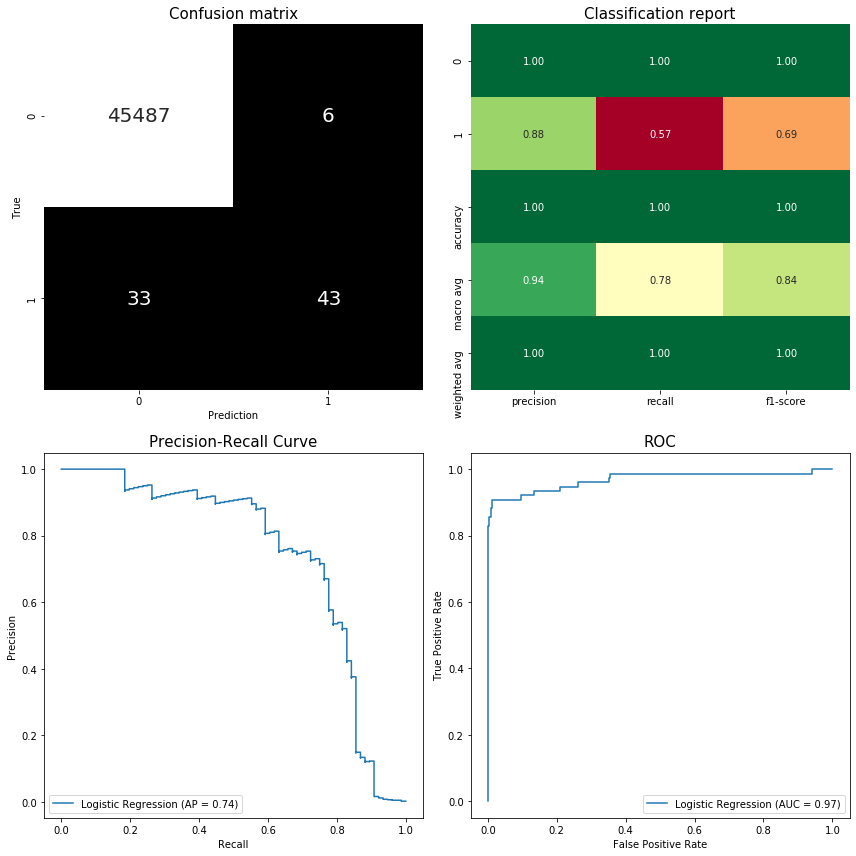

In [214]:
plot_report(baseline,X_val,y_val,'Logistic Regression',(12,12))

## 2.2 LogisticRegression with resampling

In [215]:
classweight = Pipeline_imb([('scaler',RobustScaler()),
                            ('classifier',LogisticRegression(max_iter = 100000,
                                                             class_weight = 'balanced'))])

undersampling = Pipeline_imb([('scaler',RobustScaler()),
                              ('undersampling',RandomUnderSampler(random_state = 26)),
                              ('classifier',LogisticRegression(max_iter = 100000))])

oversampling = Pipeline_imb([('scaler',RobustScaler()),
                             ('undersampling',RandomOverSampler(random_state = 26)),
                             ('classifier',LogisticRegression(max_iter = 100000))])

smote = Pipeline_imb([('scaler',RobustScaler()),
                      ('undersampling',SMOTE(random_state = 26)),
                      ('classifier',LogisticRegression(max_iter = 100000))])


classweight.fit(X_train,y_train)
undersampling.fit(X_train,y_train)
oversampling.fit(X_train,y_train)
smote.fit(X_train,y_train)

Pipeline(memory=None,
         steps=[('scaler',
                 RobustScaler(copy=True, quantile_range=(25.0, 75.0),
                              with_centering=True, with_scaling=True)),
                ('undersampling',
                 SMOTE(k_neighbors=5, n_jobs=None, random_state=26,
                       sampling_strategy='auto')),
                ('classifier',
                 LogisticRegression(C=1.0, class_weight=None, dual=False,
                                    fit_intercept=True, intercept_scaling=1,
                                    l1_ratio=None, max_iter=100000,
                                    multi_class='auto', n_jobs=None,
                                    penalty='l2', random_state=None,
                                    solver='lbfgs', tol=0.0001, verbose=0,
                                    warm_start=False))],
         verbose=False)

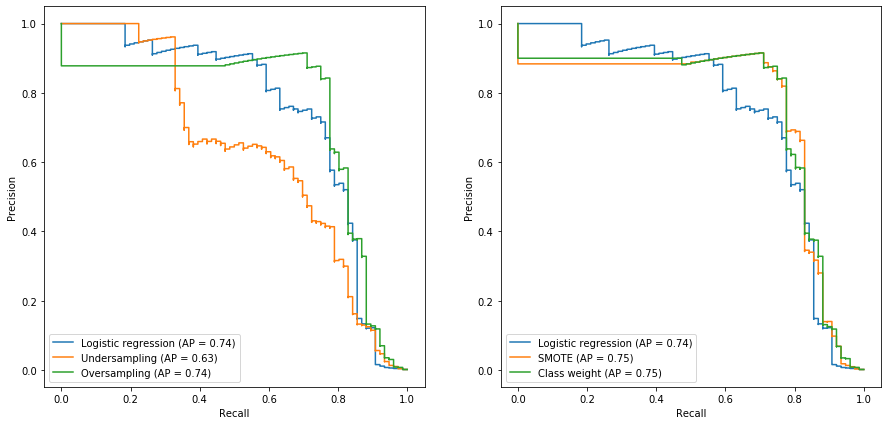

In [216]:
f, ax = plt.subplots(ncols = 2, figsize=(15,7))

'''PR Curve'''
plot_precision_recall_curve(baseline,X_val,y_val,name = 'Logistic regression',ax=ax[0])
plot_precision_recall_curve(undersampling,X_val,y_val,name = 'Undersampling',ax=ax[0])
plot_precision_recall_curve(oversampling,X_val,y_val,name = 'Oversampling',ax=ax[0])


'''PR Curve'''
plot_precision_recall_curve(baseline,X_val,y_val,name = 'Logistic regression',ax=ax[1])
plot_precision_recall_curve(smote,X_val,y_val,name = 'SMOTE',ax=ax[1])
plot_precision_recall_curve(classweight,X_val,y_val,name = 'Class weight',ax=ax[1])

plt.show()

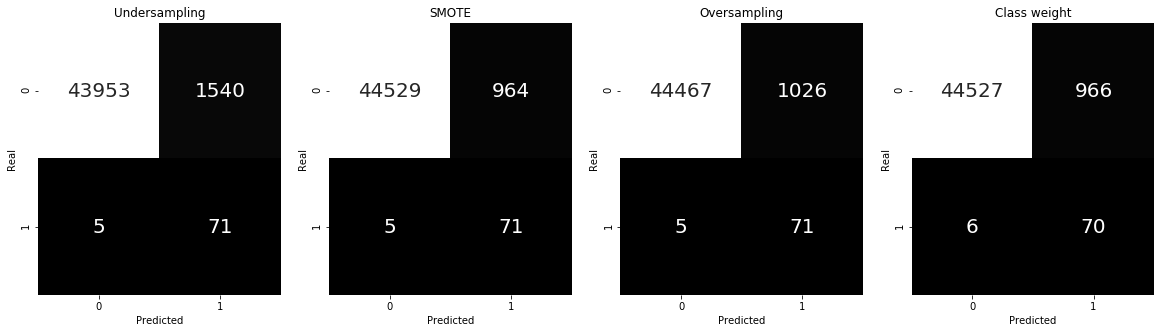

In [217]:
f,ax = plt.subplots( ncols = 4, figsize=(20,5))

sns.heatmap(confusion_matrix(y_val,undersampling.predict(X_val)), annot = True, 
            cbar = False, ax= ax[0],fmt='d', cmap = 'gray',annot_kws={"fontsize":20})

sns.heatmap(confusion_matrix(y_val,oversampling.predict(X_val)), annot = True, 
            cbar = False, ax= ax[1],fmt='d', cmap = 'gray',annot_kws={"fontsize":20})

sns.heatmap(confusion_matrix(y_val,smote.predict(X_val)), annot = True, 
            cbar = False, ax= ax[2],fmt='d', cmap = 'gray',annot_kws={"fontsize":20})

sns.heatmap(confusion_matrix(y_val,classweight.predict(X_val)), annot = True, 
            cbar = False, ax= ax[3],fmt='d', cmap = 'gray',annot_kws={"fontsize":20})

ax[0].set_title('Undersampling')
ax[1].set_title('SMOTE')
ax[2].set_title('Oversampling')
ax[3].set_title('Class weight')

ax[0].set_xlabel('Predicted')
ax[1].set_xlabel('Predicted')
ax[2].set_xlabel('Predicted')
ax[3].set_xlabel('Predicted')

ax[0].set_ylabel('Real')
ax[1].set_ylabel('Real')
ax[2].set_ylabel('Real')
ax[3].set_ylabel('Real')

plt.show()

We have reached more recall with all the methods, but also we have more False Positives. This is a classic trade off between detecting all fraud and getting more FP or having a low FP and less frauds detected.


Metrics:
https://github.com/leogcalderon/Applied_ML2020/tree/master/Evaluation

Imbalanced:
https://github.com/leogcalderon/Applied_ML2020/tree/master/Imbalanced

In [243]:
lrr = recall_score(y_val,baseline.predict(X_val))
usr = recall_score(y_val,undersampling.predict(X_val))
ovr = recall_score(y_val,oversampling.predict(X_val))
sr = recall_score(y_val,smote.predict(X_val))
cwr = recall_score(y_val,classweight.predict(X_val))

headers = ['Logistic regression','Undersampling','Oversampling','SMOTE','Class weight']
print('Recall\n--------------------------------------------------------------------------------')
print(f'{headers[0]:>15s}{headers[1]:>15s}{headers[2]:>15s}{headers[3]:>14s}{headers[4]:>20s}')
print(f'{lrr:^20.2f}{usr:^15.2f}{ovr:^15.2f}{sr:^20.2f}{cwr:^15.2f}')

lrp = precision_score(y_val,baseline.predict(X_val))
usp = precision_score(y_val,undersampling.predict(X_val))
ovp = precision_score(y_val,oversampling.predict(X_val))
srp = precision_score(y_val,smote.predict(X_val))
cwp = precision_score(y_val,classweight.predict(X_val))

headers = ['Logistic regression','Undersampling','Oversampling','SMOTE','Class weight']
print('\n\nPrecision\n--------------------------------------------------------------------------------')
print(f'{headers[0]:>15s}{headers[1]:>15s}{headers[2]:>15s}{headers[3]:>14s}{headers[4]:>20s}')
print(f'{lrp:^20.2f}{usp:^15.2f}{ovp:^15.2f}{srp:^20.2f}{cwp:^15.2f}')

Recall
--------------------------------------------------------------------------------
Logistic regression  Undersampling   Oversampling         SMOTE        Class weight
        0.57             0.93           0.93              0.93             0.92      


Precision
--------------------------------------------------------------------------------
Logistic regression  Undersampling   Oversampling         SMOTE        Class weight
        0.88             0.04           0.07              0.06             0.07      


Also,we can change the threshold for our classifier. With the F-Score (harmonic mean of recall and precision) we can find the threshold that "maximizes both values at the same time" (because we are search the best combination of both, not only max one).

*Source: https://machinelearningmastery.com/threshold-moving-for-imbalanced-classification/*

In [221]:
def to_labels(pos_probs, threshold):
    return (pos_probs >= threshold).astype('int')

probs = smote.predict_proba(X_val)[:,1]
thresholds = np.arange(0, 1, 0.001)
scores = [f1_score(y_val, to_labels(probs, t)) for t in thresholds]
ix = np.argmax(scores)

print('Threshold=%.3f \nF-Score=%.5f' % (thresholds[ix], scores[ix]))

Threshold=0.996 
F-Score=0.74390


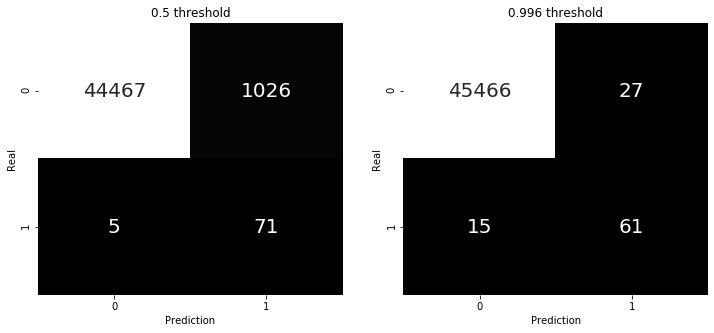

In [256]:

f,ax = plt.subplots( ncols = 2, figsize=(12,5))

sns.heatmap(confusion_matrix(y_val,smote.predict(X_val)), annot = True, 
            cbar = False, ax = ax[0], fmt='d', cmap = 'gray',annot_kws={"fontsize":20})

sns.heatmap(confusion_matrix(y_val, to_labels(probs,thresholds[ix])), annot = True, 
            cbar = False,ax = ax[1], fmt='d', cmap = 'gray',annot_kws={"fontsize":20})

ax[0].set_title('0.5 threshold')
ax[1].set_title('0.996 threshold')

ax[0].set_xlabel('Prediction')
ax[0].set_ylabel('Real')

ax[1].set_xlabel('Prediction')
ax[1].set_ylabel('Real')

plt.show()

We can see that in the validation set the classifier have 97% (1026 to 27) less False Positives, but the False Negatives have increased 300% (5 to 15).

So, depending on our goals it is our threshold:
- We want to catch the vast majority of frauds ?
- We want to catch most of the frauds and have a low false positive ?

**The final model for Logistic Regression will be:**
- SMOTE technique for resampling
- Threshold = 0.996

In [270]:
lr_pipe = Pipeline_imb([('scaler',RobustScaler()),
                        ('smote',SMOTE()),
                        ('model',LogisticRegression(max_iter=10000))])

lr_pipe.fit(pd.concat([X_train,X_val]),np.concatenate((y_train,y_val)))

Pipeline(memory=None,
         steps=[('scaler',
                 RobustScaler(copy=True, quantile_range=(25.0, 75.0),
                              with_centering=True, with_scaling=True)),
                ('smote',
                 SMOTE(k_neighbors=5, n_jobs=None, random_state=None,
                       sampling_strategy='auto')),
                ('model',
                 LogisticRegression(C=1.0, class_weight=None, dual=False,
                                    fit_intercept=True, intercept_scaling=1,
                                    l1_ratio=None, max_iter=10000,
                                    multi_class='auto', n_jobs=None,
                                    penalty='l2', random_state=None,
                                    solver='lbfgs', tol=0.0001, verbose=0,
                                    warm_start=False))],
         verbose=False)

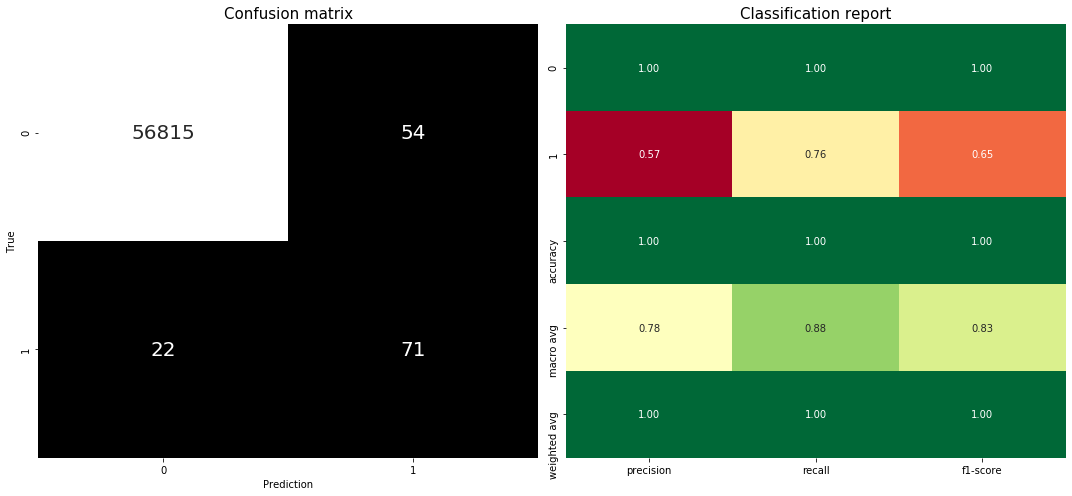

In [296]:
pred = to_labels(lr_pipe.predict_proba(X_test)[:,1],thresholds[ix])
pred_report(pred,X_test,y_test,(15,7))

## 2.2 Isolation forest

## 2.3 Autoencoder